# KohakuBoard DuckDB Viewer

Interactive notebook to view and analyze KohakuBoard data stored in DuckDB.

**Note:** Run this notebook from the project root directory.

In [4]:
import duckdb
import pandas as pd
from pathlib import Path
import json
from IPython.display import display, Image as IPImage, HTML
import base64

## 1. Find Latest Board

Automatically selects the most recent board from `./kohakuboard/`

In [5]:
# Get latest board directory
kohakuboard_dir = Path("../kohakuboard")

if not kohakuboard_dir.exists():
    raise FileNotFoundError("No kohakuboard directory found. Run an example first!")

# Get all board directories sorted by modification time
board_dirs = sorted(
    [d for d in kohakuboard_dir.iterdir() if d.is_dir()],
    key=lambda x: x.stat().st_mtime,
    reverse=True,
)

if not board_dirs:
    raise FileNotFoundError("No boards found in kohakuboard directory")

latest_board = board_dirs[0]
print(f"📊 Latest board: {latest_board.name}")

# Load metadata
metadata_file = latest_board / "metadata.json"
if metadata_file.exists():
    with open(metadata_file) as f:
        metadata = json.load(f)
    print(f"\n📝 Board Info:")
    print(f"   Name: {metadata['name']}")
    print(f"   Backend: {metadata.get('backend', 'unknown')}")
    print(f"   Created: {metadata['created_at']}")
    print(f"   Config: {metadata.get('config', {})}")
else:
    metadata = {}
    print("⚠️  No metadata.json found")

# Check backend and find database file
backend = metadata.get("backend", "parquet")
db_file = latest_board / "data" / "board.duckdb"

if backend == "duckdb" and db_file.exists():
    print(f"\n✅ DuckDB file found: {db_file}")
    USE_DUCKDB = True
elif (latest_board / "data" / "metrics.parquet").exists():
    print(f"\n✅ Parquet files found (legacy backend)")
    USE_DUCKDB = False
else:
    raise FileNotFoundError("No data files found in board directory")

📊 Latest board: 20251026_020132_6899c319

📝 Board Info:
   Name: advanced_example
   Backend: duckdb
   Created: 2025-10-25T18:01:32.494474+00:00
   Config: {'model': 'ResNet50', 'dataset': 'ImageNet', 'optimizer': 'AdamW', 'lr': 0.001, 'batch_size': 64}

✅ DuckDB file found: ..\kohakuboard\20251026_020132_6899c319\data\board.duckdb


## 2. Connect to Database

Opens the DuckDB database or Parquet files

In [6]:
if USE_DUCKDB:
    # Connect to DuckDB
    conn = duckdb.connect(str(db_file), read_only=True)
    print("✅ Connected to DuckDB")

    # List tables
    tables = conn.execute("SHOW TABLES").df()
    print(f"\n📋 Available tables: {tables['name'].tolist()}")
else:
    # Use Parquet files directly
    conn = duckdb.connect(":memory:")
    print("✅ Using Parquet files")

    # Register Parquet files as views
    data_dir = latest_board / "data"
    if (data_dir / "metrics.parquet").exists():
        conn.execute(
            f"CREATE VIEW metrics AS SELECT * FROM '{data_dir / 'metrics.parquet'}'"
        )
    if (data_dir / "media.parquet").exists():
        conn.execute(
            f"CREATE VIEW media AS SELECT * FROM '{data_dir / 'media.parquet'}'"
        )
    if (data_dir / "tables.parquet").exists():
        conn.execute(
            f"CREATE VIEW tables AS SELECT * FROM '{data_dir / 'tables.parquet'}'"
        )

    print("\n📋 Available views: metrics, media, tables")

✅ Connected to DuckDB

📋 Available tables: ['media', 'metrics', 'tables']


## 3. Explore Metrics

Query and visualize scalar metrics

In [7]:
# Get metrics overview
metrics_summary = conn.execute(
    """
    SELECT 
        COUNT(*) as total_rows,
        MIN(step) as min_step,
        MAX(step) as max_step,
        COUNT(DISTINCT global_step) as num_global_steps
    FROM metrics
"""
).df()

print("📊 Metrics Summary:")
display(metrics_summary)

📊 Metrics Summary:


,total_rows,min_step,max_step,num_global_steps
0,505,0,528,5


In [8]:
# Get all column names (metrics)
metrics_cols = conn.execute("DESCRIBE metrics").df()
metric_names = [
    col
    for col in metrics_cols["column_name"].tolist()
    if col not in ["step", "global_step"]
]

print(f"\n📈 Available metrics ({len(metric_names)}):")
for i, metric in enumerate(metric_names, 1):
    print(f"   {i}. {metric}")


📈 Available metrics (5):
   1. learning_rate
   2. batch_loss
   3. epoch
   4. epoch_train_loss
   5. epoch_val_loss


In [9]:
# View all metrics data
df_metrics = conn.execute("SELECT * FROM metrics ORDER BY step").df()
print(f"\n📊 All Metrics ({len(df_metrics)} rows):")
display(df_metrics.head(20))
print("\n...")
display(df_metrics.tail(20))


📊 All Metrics (505 rows):


,step,global_step,learning_rate,batch_loss,epoch,epoch_train_loss,epoch_val_loss
0,0,0,0.001,2.074016,NaN,NaN,NaN
1,2,0,0.001,1.896194,NaN,NaN,NaN
2,3,0,0.001,1.711266,NaN,NaN,NaN
3,4,0,0.001,2.005208,NaN,NaN,NaN
4,5,0,0.001,1.948694,NaN,NaN,NaN
5,6,0,0.001,2.089909,NaN,NaN,NaN
6,7,0,0.001,1.760201,NaN,NaN,NaN
7,8,0,0.001,1.968418,NaN,NaN,NaN
8,9,0,0.001,1.846266,NaN,NaN,NaN
9,10,0,0.001,2.147081,NaN,NaN,NaN



...


,step,global_step,learning_rate,batch_loss,epoch,epoch_train_loss,epoch_val_loss
485,508,4,0.000656,0.094331,NaN,NaN,NaN
486,509,4,0.000656,0.307423,NaN,NaN,NaN
487,510,4,0.000656,0.368513,NaN,NaN,NaN
488,511,4,0.000656,0.352629,NaN,NaN,NaN
489,512,4,0.000656,0.437840,NaN,NaN,NaN
490,513,4,0.000656,0.477960,NaN,NaN,NaN
491,514,4,0.000656,0.331713,NaN,NaN,NaN
492,515,4,0.000656,0.610509,NaN,NaN,NaN
493,516,4,0.000656,0.434632,NaN,NaN,NaN
494,517,4,0.000656,0.550188,NaN,NaN,NaN


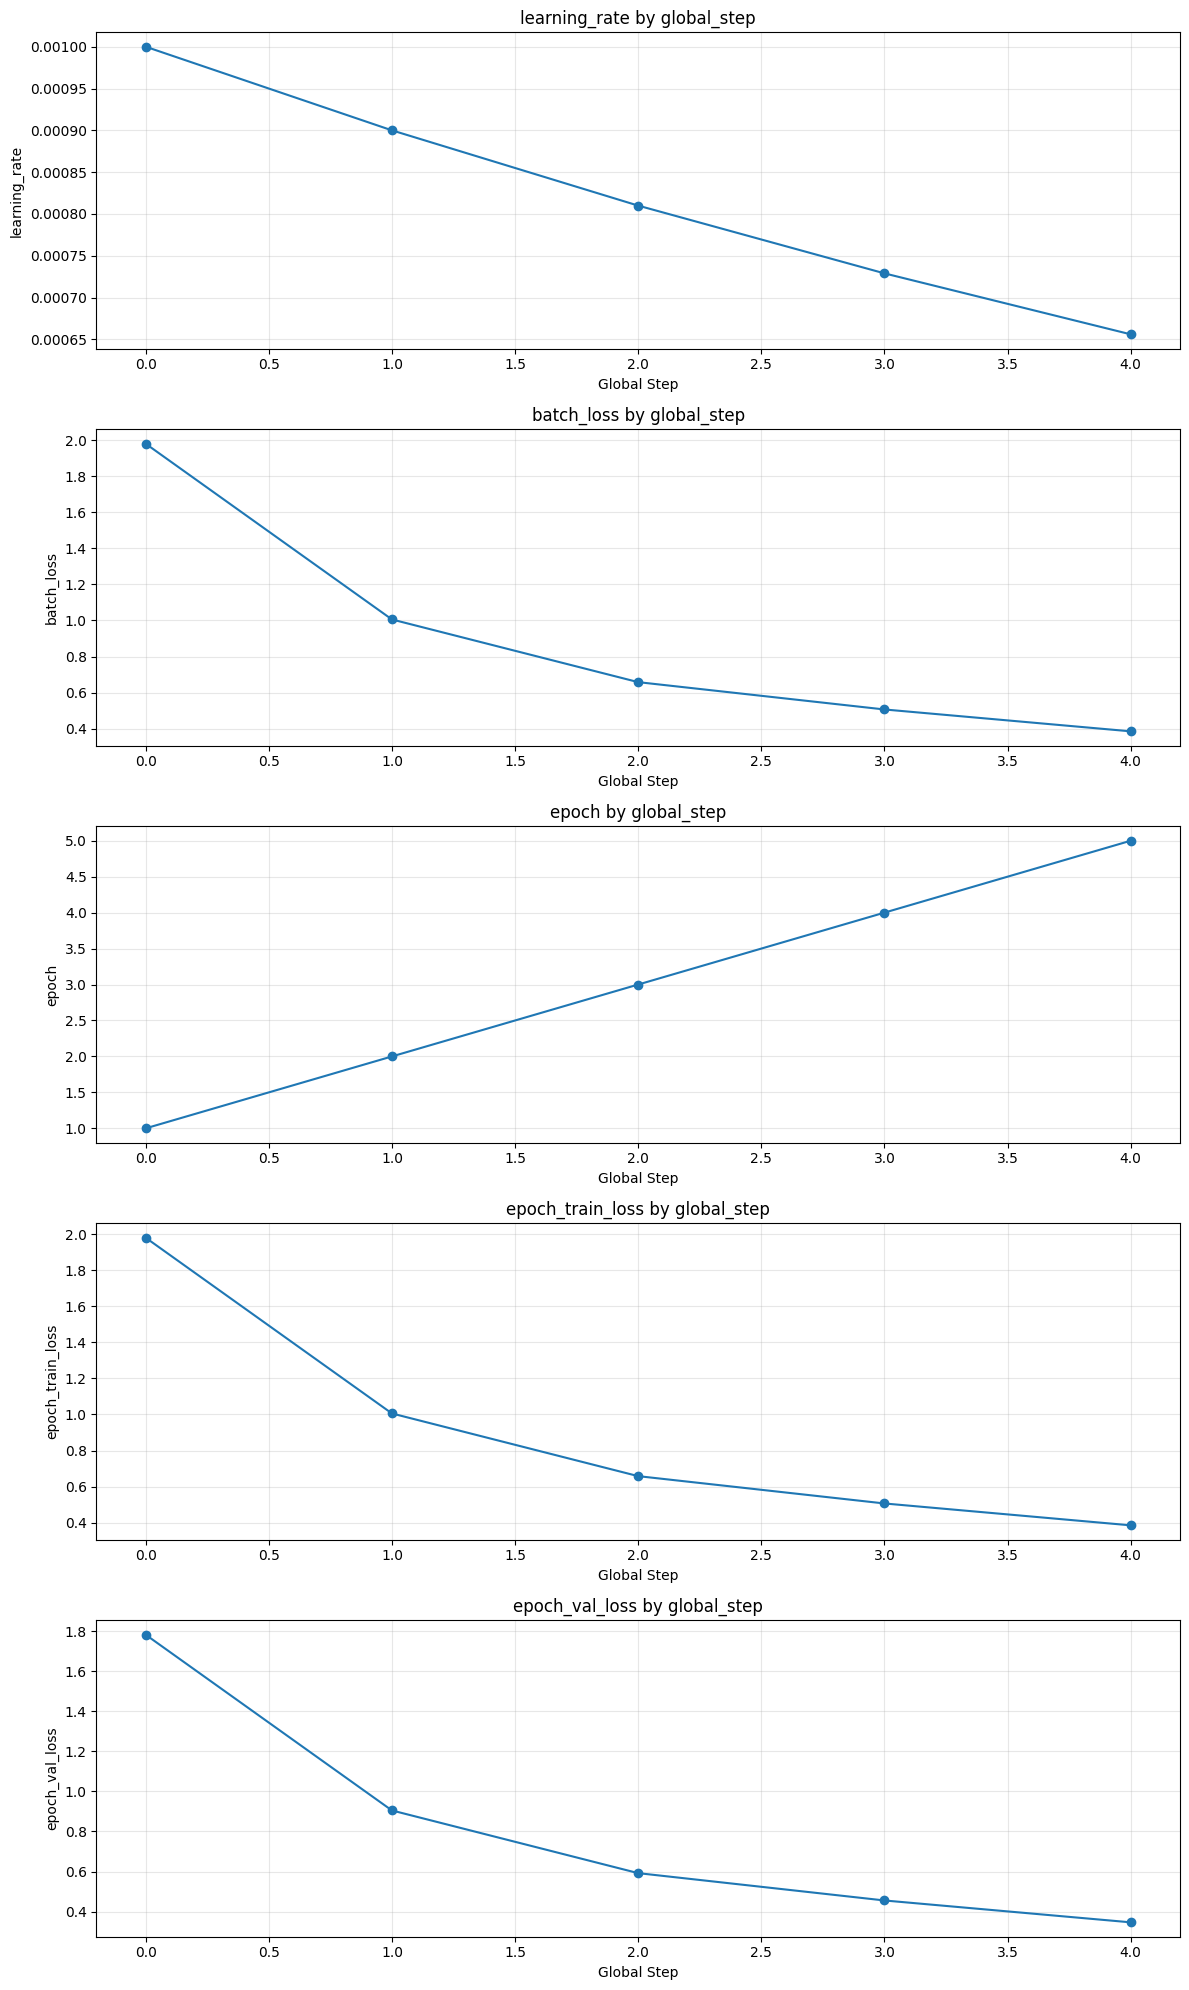

In [13]:
# Plot metrics by global_step (if available)
import matplotlib.pyplot as plt

if "global_step" in df_metrics.columns and df_metrics["global_step"].notna().any():
    # Group by global_step and calculate mean for each metric
    grouped = df_metrics.groupby("global_step").mean(numeric_only=True)

    # Plot each metric
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(12, 4 * len(metric_names)))
    if len(metric_names) == 1:
        axes = [axes]

    for ax, metric in zip(axes, metric_names):
        if metric in grouped.columns:
            grouped[metric].plot(ax=ax, marker="o")
            ax.set_title(f"{metric} by global_step")
            ax.set_xlabel("Global Step")
            ax.set_ylabel(metric)
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No global_step data for plotting")

## 4. Explore Media

View logged images, videos, audio

In [14]:
# Get media summary
media_summary = conn.execute(
    """
    SELECT 
        type,
        COUNT(*) as count,
        COUNT(DISTINCT name) as unique_names
    FROM media
    GROUP BY type
"""
).df()

print("🖼️  Media Summary:")
display(media_summary)

🖼️  Media Summary:


,type,count,unique_names
0,image,80,1


In [15]:
# View all media logs
df_media = conn.execute("SELECT * FROM media ORDER BY step").df()
print(f"\n🖼️  All Media ({len(df_media)} rows):")
display(df_media)


🖼️  All Media (80 rows):


,step,global_step,name,caption,media_id,type,filename,path,size_bytes,format,width,height
0,1,0,predictions,"Predictions at epoch 1, batch 0",5dd711c488c357e975dd6f90541c95f50809bfab4954a3...,image,predictions_0_00000001_5dd711c4.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
1,1,0,predictions,"Predictions at epoch 1, batch 0",381c49f3a7e7e7b3e5f52111c1c88227d9a75dd3b207db...,image,predictions_1_00000001_381c49f3.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
2,1,0,predictions,"Predictions at epoch 1, batch 0",ca1cc2b699fa4fcb0e535ccf37d5ad25efb7605fe4c4a2...,image,predictions_2_00000001_ca1cc2b6.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
3,1,0,predictions,"Predictions at epoch 1, batch 0",38fdcbd46473e88ef6572beab1bfb621e242de1a5adfb1...,image,predictions_3_00000001_38fdcbd4.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
4,32,0,predictions,"Predictions at epoch 1, batch 30",255773fd7d23dd732b9714367f2c2dccf1f06404b03585...,image,predictions_0_00000032_255773fd.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75,487,4,predictions,"Predictions at epoch 5, batch 60",23876c1a06d1b1853749e27c148cb21ae95a7cc90dec38...,image,predictions_3_00000487_23876c1a.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
76,518,4,predictions,"Predictions at epoch 5, batch 90",4497db8868ef4f57b56dcc89bc573f0e9995f8c7c61297...,image,predictions_0_00000518_4497db88.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
77,518,4,predictions,"Predictions at epoch 5, batch 90",3c0b8fa051be64c9d5b82844ca4d2d62ab8dcfd1b7edf3...,image,predictions_1_00000518_3c0b8fa0.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64
78,518,4,predictions,"Predictions at epoch 5, batch 90",b4ef0fa60d57131c56832c3e5c036f98901eefe83d0ca9...,image,predictions_2_00000518_b4ef0fa6.png,C:\Users\kohaku\Desktop\code\KohakuHub\kohakub...,<NA>,None,64,64


🖼️  Sample Images:

Step 1 - predictions
Caption: Predictions at epoch 1, batch 0


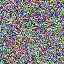


Step 1 - predictions
Caption: Predictions at epoch 1, batch 0


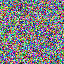


Step 1 - predictions
Caption: Predictions at epoch 1, batch 0


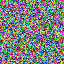


Step 1 - predictions
Caption: Predictions at epoch 1, batch 0


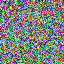


Step 32 - predictions
Caption: Predictions at epoch 1, batch 30


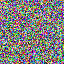

In [16]:
# Display sample images
images = conn.execute(
    """
    SELECT * FROM media 
    WHERE type = 'image' 
    LIMIT 5
"""
).df()

if len(images) > 0:
    print("🖼️  Sample Images:")
    for idx, row in images.iterrows():
        print(f"\nStep {row['step']} - {row['name']}")
        if row.get("caption"):
            print(f"Caption: {row['caption']}")

        # Display image if file exists
        if pd.notna(row.get("path")) and Path(row["path"]).exists():
            display(IPImage(filename=row["path"], width=300))
        else:
            print(f"⚠️  Image file not found: {row.get('path')}")
else:
    print("No images found")

## 5. Explore Tables

View logged table data

In [ ]:
# Get all tables
df_tables = conn.execute("SELECT * FROM tables ORDER BY step").df()
print(f"📋 All Tables ({len(df_tables)} rows):")
display(df_tables[["step", "global_step", "name"]])

In [ ]:
# Parse and display first table
if len(df_tables) > 0:
    first_table = df_tables.iloc[0]

    print(f"\n📋 Table: {first_table['name']} (Step {first_table['step']})")

    # Parse JSON columns
    columns = json.loads(first_table["columns"])
    column_types = json.loads(first_table["column_types"])
    rows = json.loads(first_table["rows"])

    # Create DataFrame
    table_df = pd.DataFrame(rows, columns=columns)
    display(table_df)
else:
    print("No tables found")

## 6. Custom SQL Queries

Run your own SQL queries on the data

In [ ]:
# Example: Get metrics by global_step
query = """
    SELECT 
        global_step,
        COUNT(*) as num_logs,
        AVG(batch_loss) as avg_batch_loss,
        AVG(learning_rate) as avg_lr
    FROM metrics
    WHERE global_step IS NOT NULL
    GROUP BY global_step
    ORDER BY global_step
"""

result = conn.execute(query).df()
print("📊 Metrics by Global Step:")
display(result)

In [ ]:
# Plot results
if len(result) > 0 and "avg_batch_loss" in result.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Loss plot
    ax1.plot(result["global_step"], result["avg_batch_loss"], marker="o", linewidth=2)
    ax1.set_title("Average Batch Loss by Epoch")
    ax1.set_xlabel("Global Step (Epoch)")
    ax1.set_ylabel("Average Batch Loss")
    ax1.grid(True, alpha=0.3)

    # Learning rate plot
    if "avg_lr" in result.columns:
        ax2.plot(
            result["global_step"],
            result["avg_lr"],
            marker="o",
            linewidth=2,
            color="orange",
        )
        ax2.set_title("Average Learning Rate by Epoch")
        ax2.set_xlabel("Global Step (Epoch)")
        ax2.set_ylabel("Learning Rate")
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# Custom query cell - modify as needed
custom_query = """
    SELECT * FROM metrics
    WHERE step < 100
    ORDER BY step
"""

custom_result = conn.execute(custom_query).df()
display(custom_result)

## 7. Database Statistics

File size, compression info, table sizes

In [ ]:
if USE_DUCKDB:
    # Get database file size
    db_size = db_file.stat().st_size
    print(f"💾 Database file size: {db_size / 1024 / 1024:.2f} MB")

    # Get row counts per table
    print("\n📊 Table sizes:")
    for table_name in ["metrics", "media", "tables"]:
        try:
            count = conn.execute(
                f"SELECT COUNT(*) as cnt FROM {table_name}"
            ).fetchone()[0]
            print(f"   {table_name}: {count} rows")
        except:
            print(f"   {table_name}: not found")
else:
    # Parquet file sizes
    print("💾 Parquet file sizes:")
    data_dir = latest_board / "data"
    for file in data_dir.glob("*.parquet"):
        size = file.stat().st_size / 1024
        print(f"   {file.name}: {size:.2f} KB")

# Media directory size
media_dir = latest_board / "media"
if media_dir.exists():
    media_files = list(media_dir.glob("*"))
    total_media_size = sum(f.stat().st_size for f in media_files)
    print(
        f"\n🖼️  Media storage: {len(media_files)} files, {total_media_size / 1024 / 1024:.2f} MB"
    )

## 8. Export Data

Export to CSV, JSON, or other formats

In [ ]:
# Export metrics to CSV
output_dir = latest_board / "exports"
output_dir.mkdir(exist_ok=True)

metrics_csv = output_dir / "metrics.csv"
df_metrics.to_csv(metrics_csv, index=False)
print(f"✅ Exported metrics to: {metrics_csv}")

# Export summary by global_step
if len(result) > 0:
    summary_csv = output_dir / "summary_by_epoch.csv"
    result.to_csv(summary_csv, index=False)
    print(f"✅ Exported summary to: {summary_csv}")

## 9. Cleanup

Close connections

In [ ]:
conn.close()
print("✅ Connection closed")